## Fingerprint enhancement and minutia extraction

In this lab, we will dive into convolution, image filtering, gradients and keypoints using a fingerprint detection example. The standard fingerprint recognition process relies on a basic process: capture a clear image of a fingerprint, enhance it to clearly show ridges (fingerprint lines) and binarise (threshold to binary image), then detect minutia (fingerprint line intersections or end-points of ridges). The pattern formed by these minutia is unique, and can be used for fingerprint matching and recognition.

The accompanying images show a poor quality image of a fingerprint, taken from a foggy glass surface and a kettle. Fingerprint recognition from sources like these is called latent fingerprinting, but more challenging because we can't control the conditions the fingerprint is taken under. As part of the lab, we will losely follow the steps in this paper,

> Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement: Algorithm and performance evaluation. IEEE Transactions on Pattern Analysis and Machine Intelligence 20, 8 (1998), 777 789.

to improve the image quality. The basic steps outlined in this paper are, compute average gradient orientation in blocks in image. Use this gradient orientation to select Gabor filters to enhance ridges. Tune the frequency of the gabor filters to get a good response. Filter the image with these filters and combine repsonses to return an enhanced image. 

For your implementation of this, you are required to:

1. Load the image using opencv, convert it to grey scale, and crop to the region with the fingerprint.
2. Use the opencv `cv2.equalizeHist` function to improve image contrast.
3. Implement a convolution function called `my_conv` that takes in an image, a kernel or filter, and a stride, and returns the filtered image response. Your convolution function does not need to flip the kernel or perform padding. You may use the opencv conv2d function for filtering below instead, but this function won't be able to perform strided convolutions (needed below).
4. Compute the orientation of the gradient at each pixel in the image using Sobel filtering `cv2.Sobel` (see steps below).
      * First blur the image using a Gaussian kernel with a stride of 1 `cv2.GaussianBlur`.
      * Compute the horizontal and vertical Sobel derivatives respectively. Use matplotlib to show the output images.
      * Compute the gradient orientation using `atan2(Gy,Gx)`. Use matplotlib to show the output images, selecting a suitable colormap to make it easier to visualise.
      * Repeat the process above, using different size kernels and standard deviations. Choose a kernel size and standard deviation that helps pick up the gradient for the ridge lines and briefly motivate why you chose this. 
5. Design a convolutional kernel to divide the image into d x d pixel image patches and compute the average gradient orientation in each. Hint, use the stride parameter together with the averaging filter describe in the lecture videos to do this. Use `numpy.histogram` functions to compute a histogram of the orientations in this response image using k orientation bins. Use matplotlib to plot the histogram. You will need to come up with good choices for the numbers k and d. 
6. Use the gabor filter code provided to generate gabor filters for each of the orientations identified by the histogram above. Filter the image using these, and use matplotlib to show both the output images and filters. 
7. Combine all the filtered responses into a single image, by taking the maximum response at each pixel. Threshold the image to leave only those pixels greater than some threshold value. Plot the final enhanced image and try to tune the threshold value to result in the clearest fingerprint. Compare with (by plotting alongside) an approach that thresholds the original image only.   
8. Use a suitable corner detector in opencv to detect minutia (corners) in the thresholded image. Show the corners using matplotlib, and compare with corners detected directly on the original image.
9. Tune the hyperparameters (kernel size, thresholds, kernel parameters etc.) to try to get the best possible fingerprint and minutia. Try the same approach using the second image provided. Save the two best quality minutia images using the opencv `cv2.imwrite` function. Load both these images and use matplotlib to show the final results.
10. Write a brief report (max 600 words) discussing which parameters affect the fingerprint quality the most, and explaining the contribution of each step above. Explain your resoning by referencing the intermediate result figures you generated. Think about the image content and justify your choices of kernel sizes, standard deviations, frequencies, bin counts etc. Did the same parameters work for both images, explain why/ why not? What are some of the limitations of the approach above?

### Academic integrity

Every lab submission will be screened for any collusion and/or plagiarism. Breaches of academic integrity will be investigated thoroughly and may result in a zero for the assessment along with interviews with the plagiarism officers at Monash University.

### Late submissions

The default late submission university penalty will apply.

### Lab Instructions and the Use of Generative AI

You may not use any built-in opencv functions for this lab, other than those used for loading/ saving an image, extracting and matching keypoints, and
computing homographies.
* You may use NumPy for array handling, and vectorizing your code (reducing
the number of for-loops) is encouraged.
* You should use Matplotlib to display images and any intermediate results.
* You may use generative AI.

### Grading
Each lab is worth 8%, and there are a number of sections and tasks with their own weighting. A task is only considered complete if you can demonstrate a working program and show an understanding of the underlying concepts. Note that later tasks should reuse code from earlier tasks.

You will be marked based on:
* The degree to which you successfully followed the steps above and correctly implemented these.
* The quality of the fingerprint enhancement and minutia detection you finally obtained.
* The quality of your discussion and interpretation of the effects of the steps above and the choice of hyperparameters. Based on the minutia detected, comment on whether you think this method would work to recognise a fingerprint.


You may use generative AI/ coding assistance and built in opencv, matplotlib or numpy functions in this lab.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Step 1: Load your image, convert to grey scale, crop and display it using matplotlib

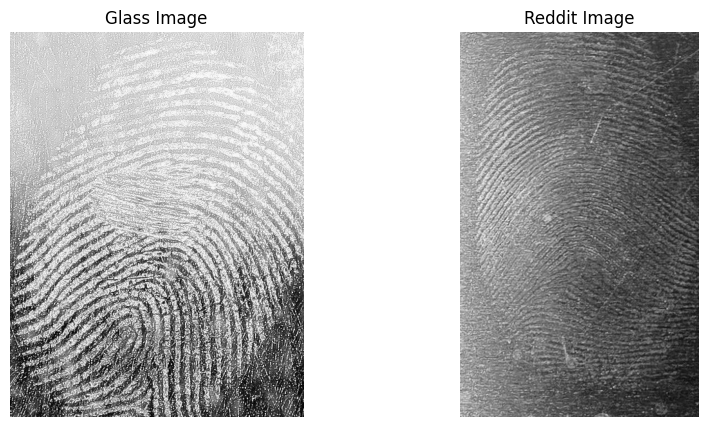

In [2]:
# Load image & Convert to grey scale
im1 = cv2.imread('glass.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread('reddit.jpeg', cv2.IMREAD_GRAYSCALE)
# Crop the image
im1 = im1[100:700, 585:1042]
im2 = im2[1655:2355, 1238:1672]

# Display images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(im1, cmap="gray")
axes[0].set_title("Glass Image")
axes[0].axis("off")

axes[1].imshow(im2, cmap="gray")
axes[1].set_title("Reddit Image")
axes[1].axis("off")

plt.show()

### Step 2: Perform histogram equalisation and show the result using matplotlib

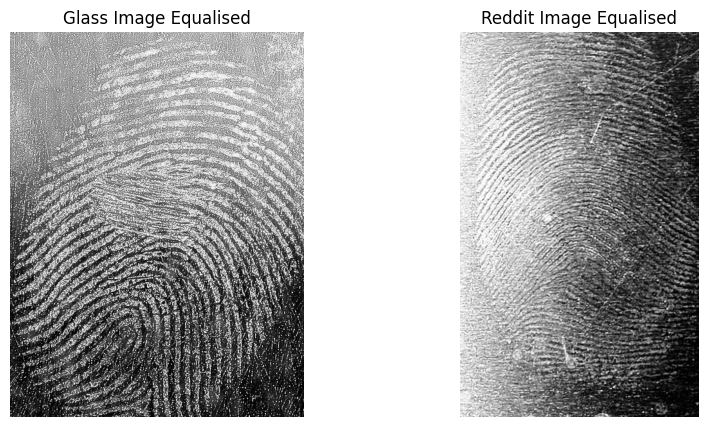

In [3]:
# Histogram equalisation 
eq1 = cv2.equalizeHist(im1)
eq2 = cv2.equalizeHist(im2)

# Display images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(eq1, cmap="gray")
axes[0].set_title("Glass Image Equalised")
axes[0].axis("off")

axes[1].imshow(eq2, cmap="gray")
axes[1].set_title("Reddit Image Equalised")
axes[1].axis("off")

plt.show()

### Step 3: Write your own strided convolution

In [4]:
# Strided Convolution
def my_conv(image, kernel, stride):
    h, w = image.shape
    kh, kw = kernel.shape

    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1
    output = np.zeros((out_h, out_w))

    for i in range(out_h):
        for j in range(out_w):
            region = image[i * stride : i * stride + kh, j * stride : j * stride + kw]
            output[i, j] = np.sum(region * kernel)

    return output

#### Step 4: Compute the orientation of the gradient at each pixel in the image using Sobel filtering

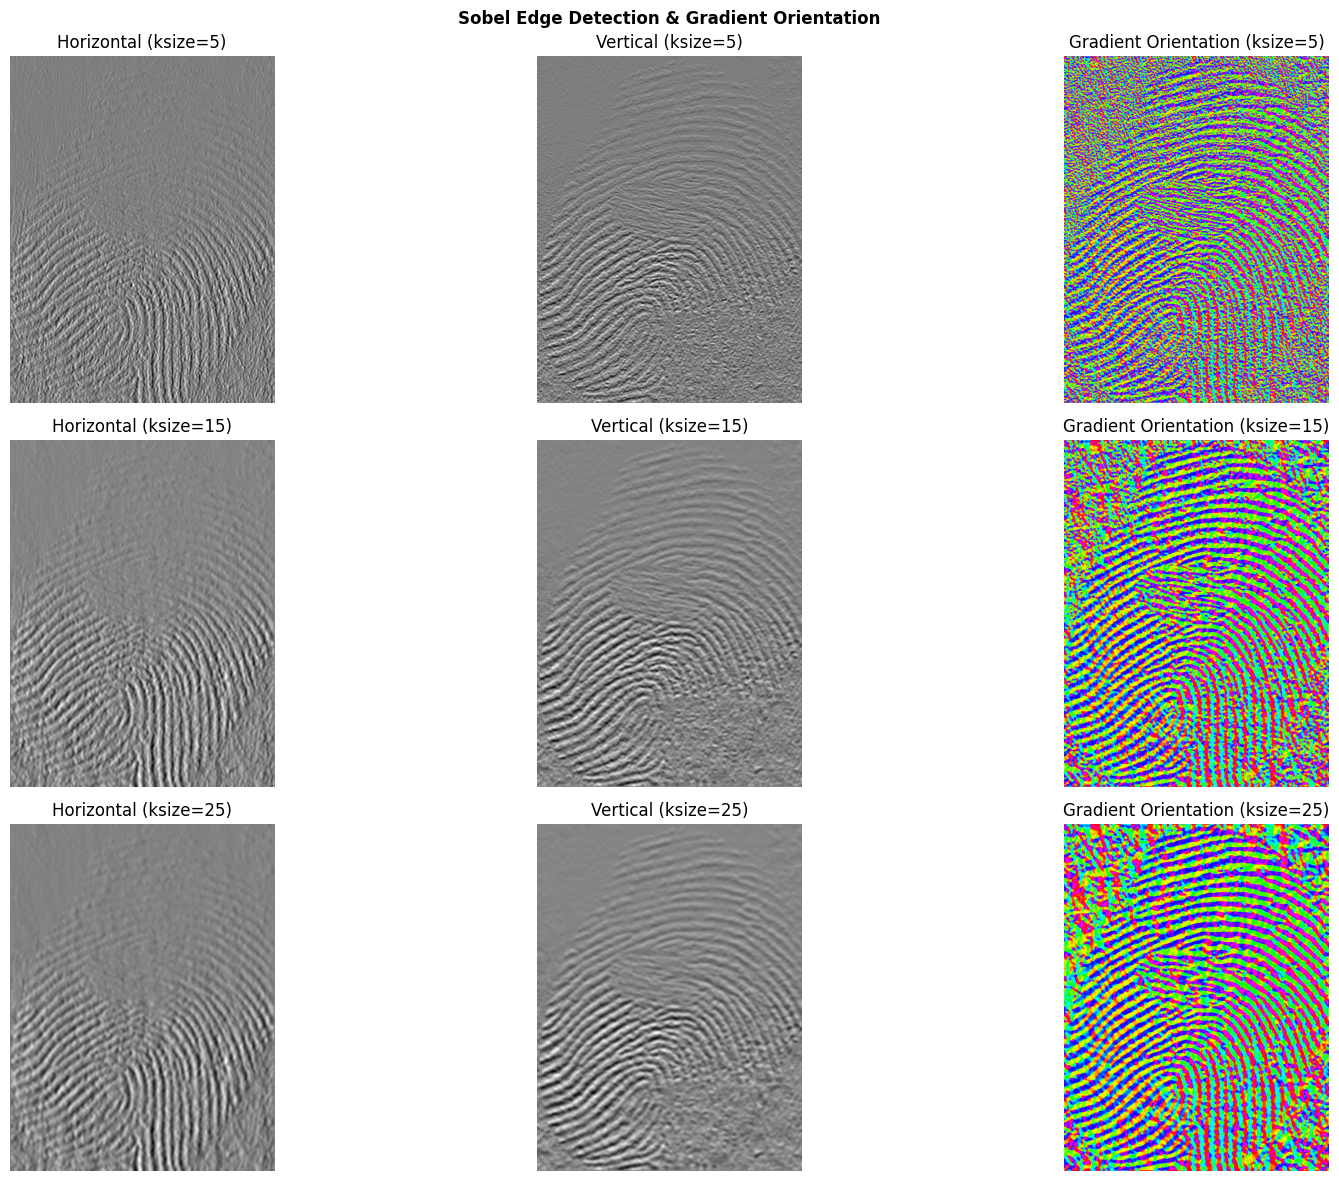

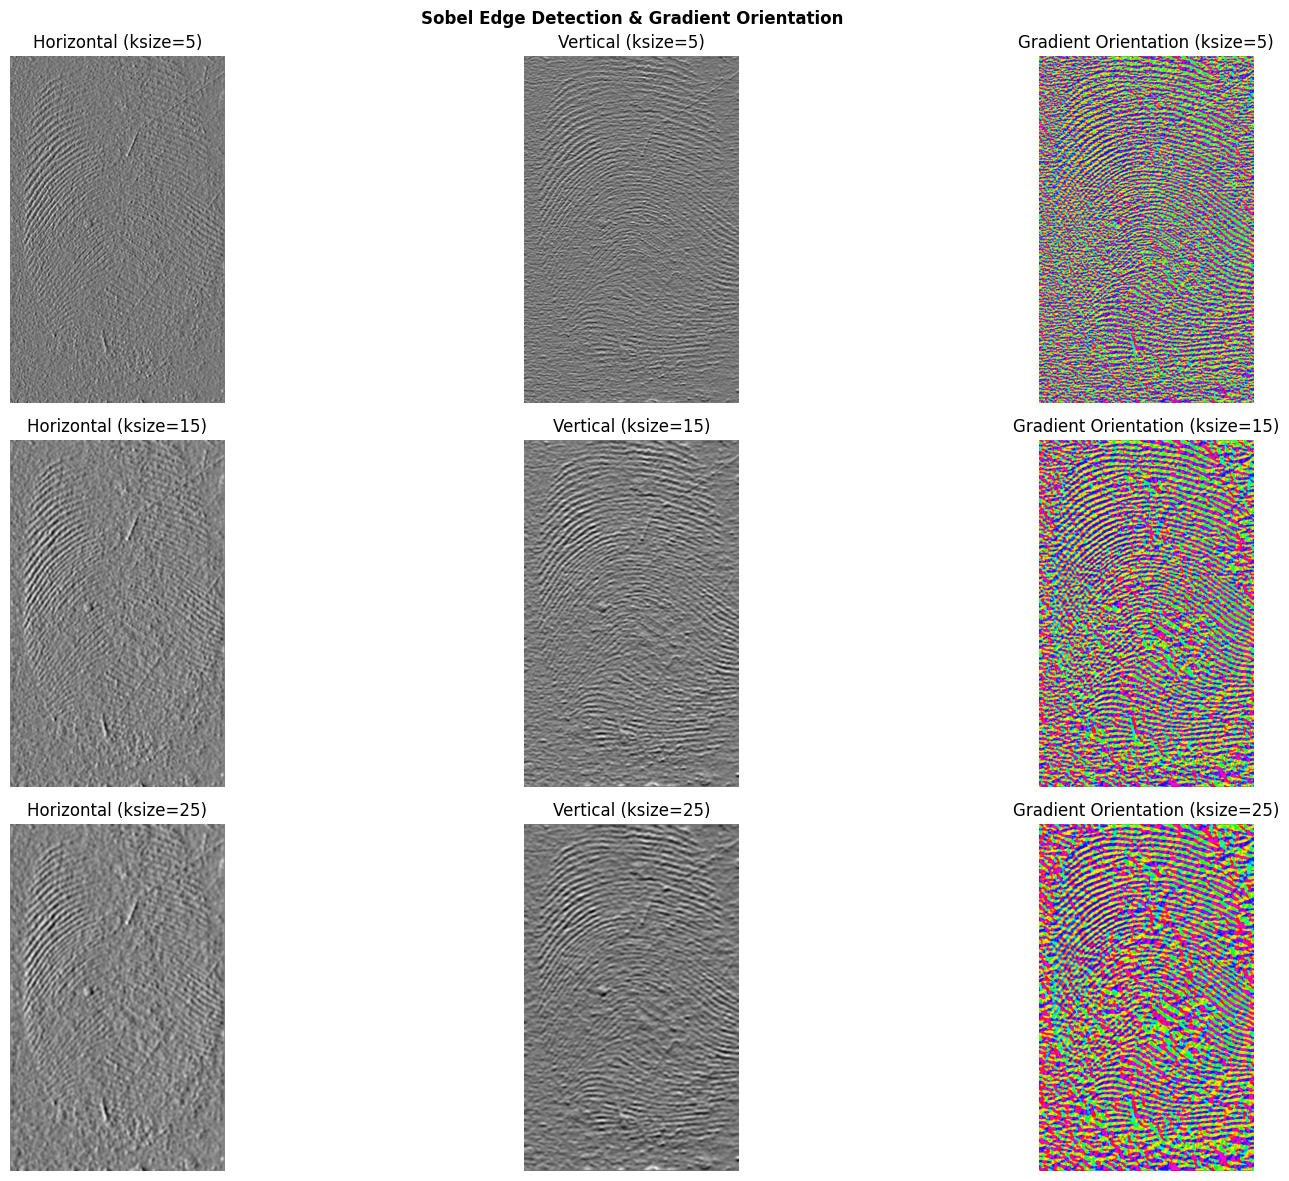

In [ ]:
def sobel_filter(img, gauss_ksize, gauss_sig, sobel_ksize):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # 3 rows, 3 columns
    fig.suptitle("Sobel Edge Detection & Gradient Orientation", fontweight='bold') 

    for i in range(3):
        # Apply Gaussian Blur
        blur_img = cv2.GaussianBlur(img, (gauss_ksize, gauss_ksize), gauss_sig)
        
        # Compute Sobel Gradients
        Gx = cv2.Sobel(blur_img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=sobel_ksize)
        Gy = cv2.Sobel(blur_img, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=sobel_ksize)
        
        # Gradient
        gradient = np.atan2(Gy,Gx)
        
        # Display Horizontal Sobel
        axes[i, 0].imshow(Gx, cmap="gray")
        axes[i, 0].set_title(f"Horizontal (ksize={sobel_ksize})")
        axes[i, 0].axis("off")

        # Display Vertical Sobel
        axes[i, 1].imshow(Gy, cmap="gray")
        axes[i, 1].set_title(f"Vertical (ksize={sobel_ksize})")
        axes[i, 1].axis("off")

        # Display Gradient Orientation
        im = axes[i, 2].imshow(gradient, cmap="hsv")
        axes[i, 2].set_title(f"Gradient Orientation (ksize={sobel_ksize})")
        axes[i, 2].axis("off")
 
        # Increase Sobel kernel size by 10 for next iteration
        sobel_ksize += 10  
        
    plt.tight_layout()
    plt.show()

    return gradient

orientation1 = sobel_filter(im1, gauss_ksize=3, gauss_sig=1.0, sobel_ksize=5)
orientation2 = sobel_filter(im2, gauss_ksize=3, gauss_sig=1.0, sobel_ksize=5)


#### Step 5: Compute the average orientation in image blocks and plot a histogram of the orientations

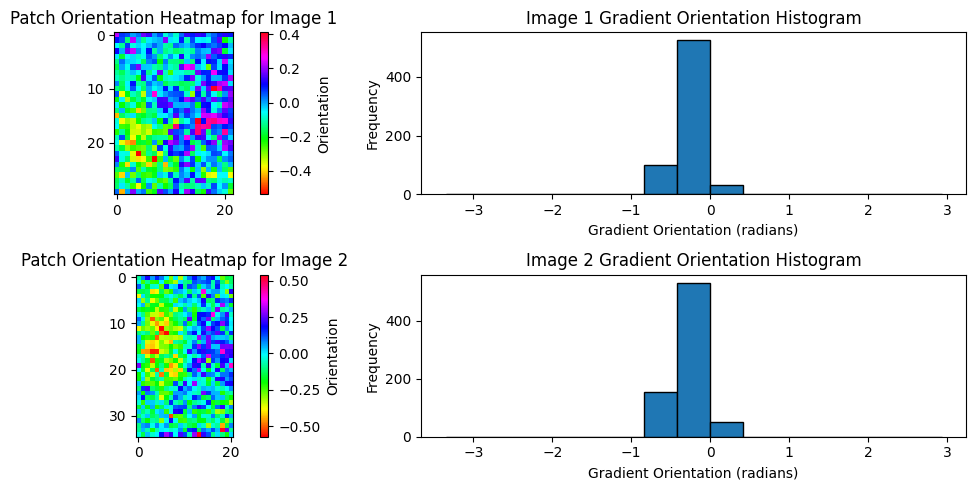

In [314]:
d = 20   # Patch size
k = 15   # Number of bins

def image_divider(img, d, k, ksize):
    # Compute Sobel Gradients on Full Image
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize)

    # Compute orientation in RADIANS
    orientation = np.arctan2(gy, gx)
    # Compute gradient magnitude
    magnitude = np.sqrt(gx**2 + gy**2)

    # Average the orientations over patches
    h, w = orientation.shape
    #avg_orientation = np.zeros((h // d, w // d))
    patch_h = h // d
    patch_w = w // d

    # Create arrays for visualization and histogram
    ori_visual = np.zeros((patch_h, patch_w))
    
    # Compute weighted average orientation per patch
    for i in range(patch_h):
        for j in range(patch_w):
            # Extract patch orientation and magnitude
            patch_orient = orientation[i*d:(i+1)*d, j*d:(j+1)*d]
            patch_mag = magnitude[i*d:(i+1)*d, j*d:(j+1)*d]
            
            # Compute weighted mean orientation
            weighted_orient = np.average(patch_orient, weights=patch_mag)
            ori_visual[i, j] = weighted_orient

    # Compute histogram using the first method's approach
    hist, bins = np.histogram(ori_visual, bins=k, range=(-np.pi, np.pi))

    return ori_visual, hist, bins

# Process both images
ori_vis1, hist1, bins1 = image_divider(im1, d, k, 18)
ori_vis2, hist2, bins2 = image_divider(im2, d, k, 18)

# Plot histograms side by side
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

# First image orientation heatmap
im1_plot = axes[0, 0].imshow(ori_vis1, cmap='hsv')
axes[0, 0].set_title('Patch Orientation Heatmap for Image 1')
fig.colorbar(im1_plot, ax=axes[0, 0], label='Orientation')

# Second image orientation heatmap
im2_plot = axes[1, 0].imshow(ori_vis2, cmap='hsv')
axes[1, 0].set_title('Patch Orientation Heatmap for Image 2')
fig.colorbar(im2_plot, ax=axes[1, 0], label='Orientation')

# Histogram for Image 1
axes[0, 1].bar(bins1[:-1], hist1, width=(2 * np.pi / k), edgecolor="black")
axes[0, 1].set_title("Image 1 Gradient Orientation Histogram")
axes[0, 1].set_xlabel("Gradient Orientation (radians)")
axes[0, 1].set_ylabel("Frequency")

# Histogram for Image 2
axes[1, 1].bar(bins2[:-1], hist2, width=(2 * np.pi / k), edgecolor="black")
axes[1, 1].set_title("Image 2 Gradient Orientation Histogram")
axes[1, 1].set_xlabel("Gradient Orientation (radians)")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

#### Step 6: Generate gabor filters for each of the orientation bins above, apply these and use matplotlib to visualise both the filters and responses

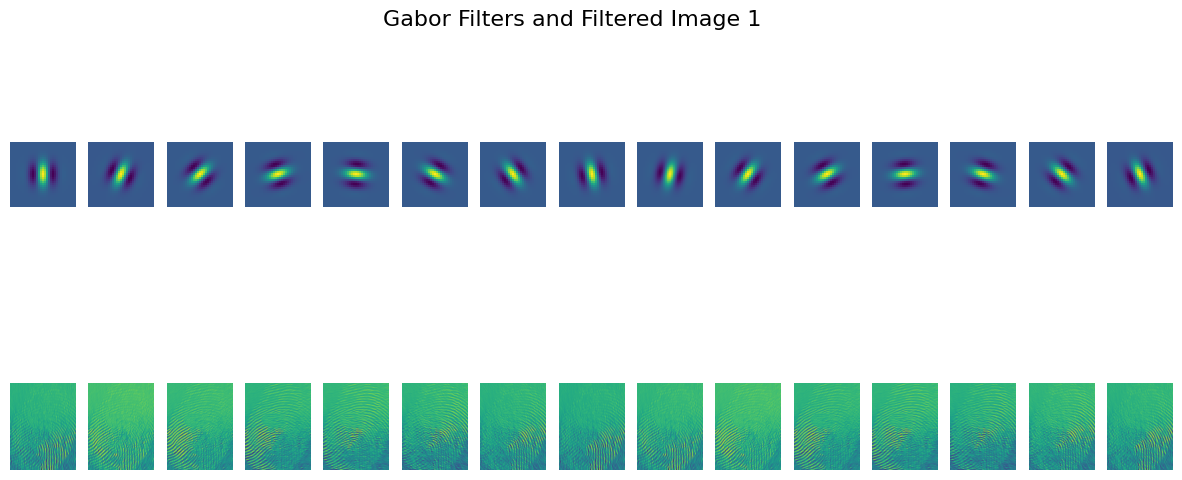

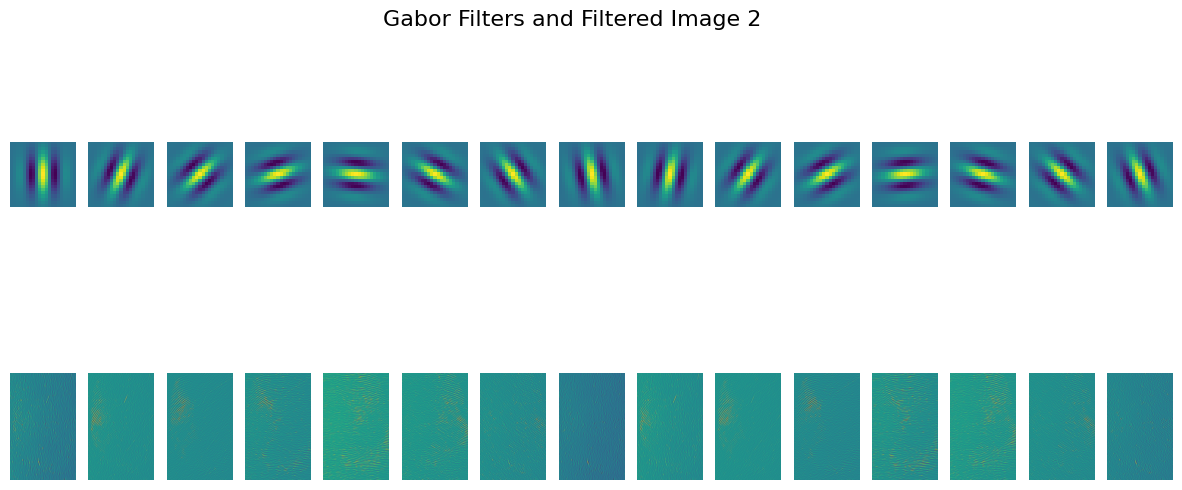

In [315]:
def gabor(theta,ksize,sigma,freq, value):
    kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, value, freq, 0, ktype=cv2.CV_64F)
    kern /= 1.0 * kern.sum() 
    return kern

# Find dominant orientations
orientations1 = bins1[:-1]
orientations2 = bins2[:-1]

gabor_filters1 = []
gabor_filters2 = []
filtered_images1 = []
filtered_images2 = []

# Generate Gabor filters for dominant orientations
for theta in orientations1:
    gabor_kernel = gabor(theta, 32, 4, 1, 12)
    gabor_filters1.append(gabor_kernel)

for theta in orientations2:
    gabor_kernel = gabor(theta, 20, 4, 0.9, 8)
    gabor_filters2.append(gabor_kernel)

# Apply Gabor filters to image 1
for gabor_kernel in gabor_filters1:
    filtered_image = my_conv(im1, gabor_kernel, stride=1)
    filtered_images1.append(filtered_image)

# Plot Gabor filters and filtered images for Image 1
fig, axes = plt.subplots(2, len(gabor_filters1), figsize=(15, 6))
fig.suptitle("Gabor Filters and Filtered Image 1", fontsize=16)
for idx, (gabor_kernel, filtered_img) in enumerate(zip(gabor_filters1, filtered_images1)):
    axes[0, idx].imshow(gabor_kernel, cmap='viridis')
    axes[0, idx].axis('off')
    axes[1, idx].imshow(filtered_img, cmap='viridis')
    axes[1, idx].axis('off')
plt.show()

# Apply Gabor filters to image 2
for gabor_kernel in gabor_filters2:
    filtered_image = my_conv(im2, gabor_kernel, stride=1)
    filtered_images2.append(filtered_image)

# Plot Gabor filters and filtered images for Image 2
fig, axes = plt.subplots(2, len(gabor_filters1), figsize=(15, 6))
fig.suptitle("Gabor Filters and Filtered Image 2", fontsize=16)
for idx, (gabor_kernel, filtered_img) in enumerate(zip(gabor_filters2, filtered_images2)):
    axes[0, idx].imshow(gabor_kernel, cmap='viridis')
    axes[0, idx].axis('off')
    axes[1, idx].imshow(filtered_img, cmap='viridis')
    axes[1, idx].axis('off')
plt.show()

#### Step 7: Combine the responses above and show the enhanced image alonside the original one, then threshold the image to retain only fingerprint information

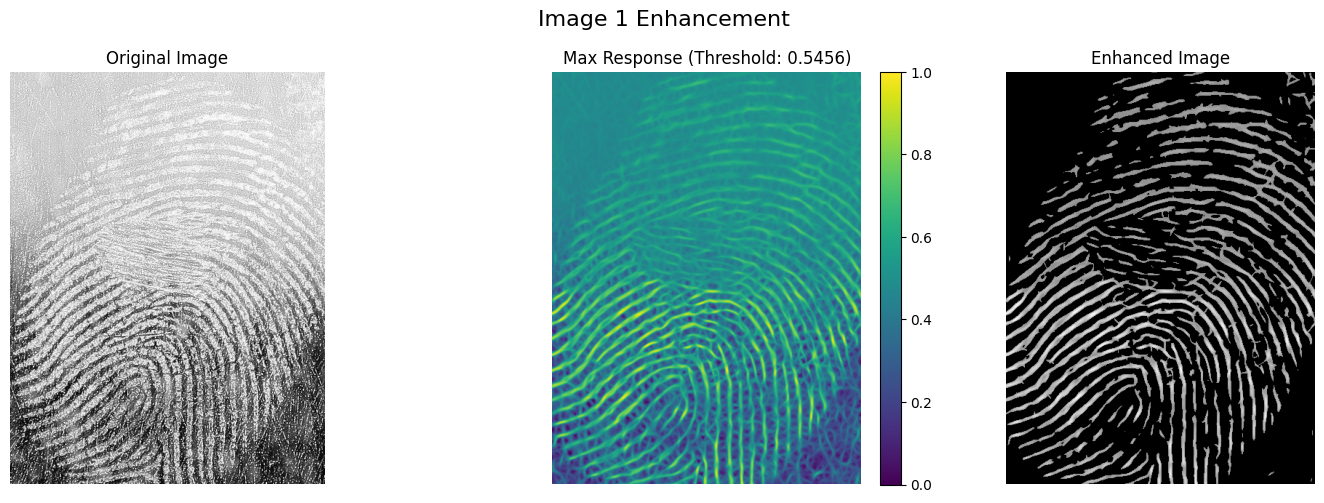

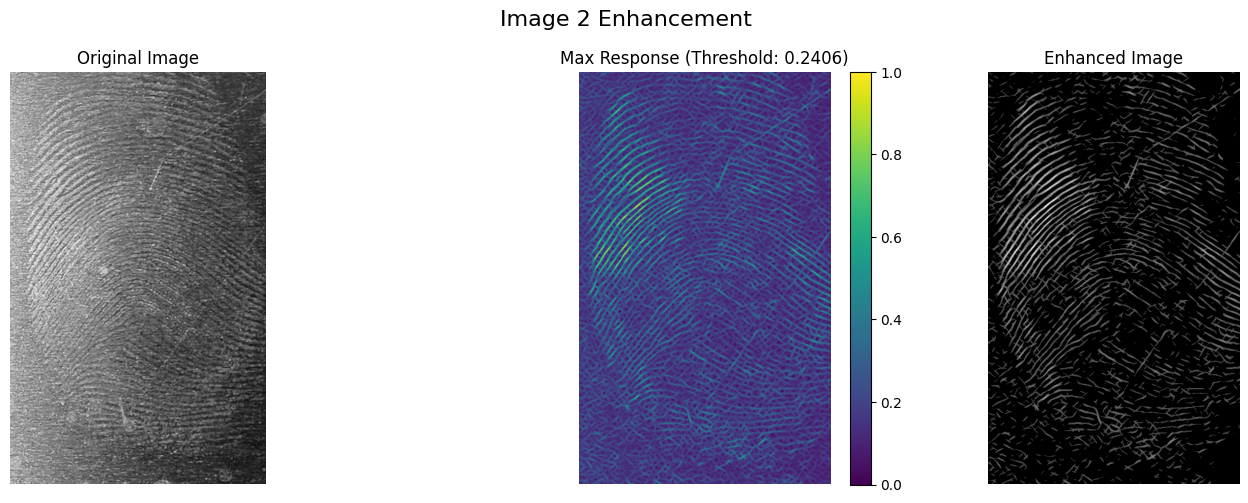

In [321]:
def enhance_image(filtered_images):
    # Take maximum response across all filters
    max_response = np.max(filtered_images, axis=0)
    
    # Normalize the max response
    max_response = (max_response - max_response.min()) / (max_response.max() - max_response.min())
    
    # Dynamic thresholding
    threshold = np.mean(max_response) + 0.5 * np.std(max_response)
    
    # Create binary mask
    enhanced_mask = max_response > threshold
    
    # Apply mask to original max response
    enhanced_image = max_response * enhanced_mask
    
    return enhanced_image, max_response, threshold

# Enhance both images
enhanced_img1, max_response1, threshold1 = enhance_image(filtered_images1)
enhanced_img2, max_response2, threshold2 = enhance_image(filtered_images2)

def plot_enhancement_comparison(original, enhanced, max_response, threshold, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    
    # Original image
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Max response
    im2 = axes[1].imshow(max_response, cmap='viridis')
    axes[1].set_title(f'Max Response (Threshold: {threshold:.4f})')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Enhanced image
    axes[2].imshow(enhanced, cmap='gray')
    axes[2].set_title('Enhanced Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_enhancement_comparison(im1, enhanced_img1, max_response1, threshold1, "Image 1 Enhancement")
plot_enhancement_comparison(im2, enhanced_img2, max_response2, threshold2, "Image 2 Enhancement")

#### Step 8: Use a corner detector to try to identify Minutia

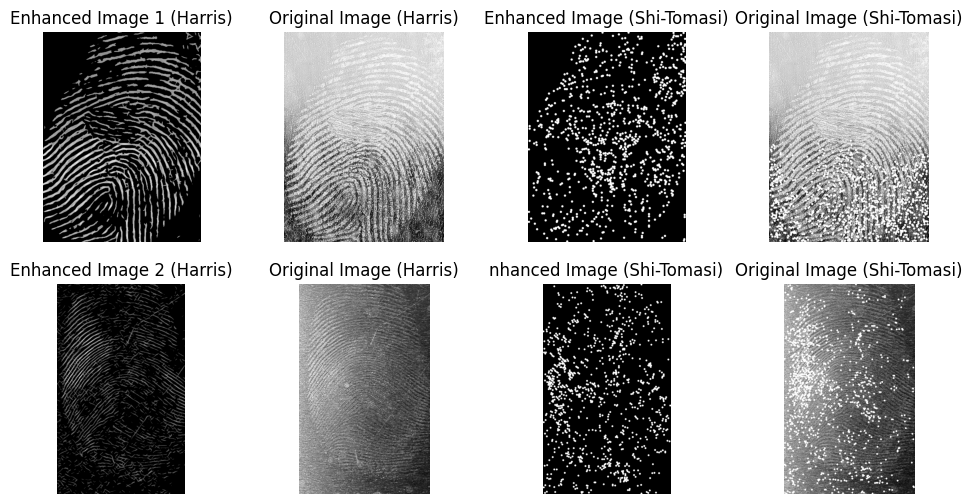

In [ ]:
def detect_corners(image, method):
    #Detect corners using Harris or Shi-Tomasi method
    gray = np.float32(image)
    
    if method == "harris":
        # Harris Corner Detection
        gray_float = np.float32(gray)  # Harris requires float32 input
        corners = cv2.cornerHarris(gray_float, blockSize=1, ksize=3, k=0.16)
        corners = cv2.dilate(corners, None) 
        threshold = 0.01 * corners.max()
        result = np.copy(image)
        result[corners > threshold] = 255 
    elif method == "shi":
        # Shi-Tomasi (Good Features to Track)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=1000, qualityLevel=0.06, minDistance=3)
        result = np.copy(image)
        if corners is not None:  # Check if corners were detected
            for corner in corners.astype(np.int32):
                x, y = corner.ravel()
                cv2.circle(result, (x, y), 3, 255, -1)

    return result

# Detect corners on the thresholded fingerprint image
corners_enhanced1_harris = detect_corners(enhanced_img1, method="harris")
corners_enhanced2_harris = detect_corners(enhanced_img2, method="harris")
corners_enhanced1_shi = detect_corners(enhanced_img1, method="shi")
corners_enhanced2_shi = detect_corners(enhanced_img2, method="shi")

# Detect corners on the original grayscale fingerprint image
corners_orig1_harris = detect_corners(im1, method="harris")
corners_orig2_harris = detect_corners(im2, method="harris")
corners_orig1_shi = detect_corners(im1, method="shi")
corners_orig2_shi = detect_corners(im2, method="shi")

# Plot the results
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

axes[0, 0].imshow(corners_enhanced1_harris, cmap="gray")
axes[0, 0].set_title("Enhanced Image 1 (Harris)")
axes[0, 0].axis("off")

axes[0, 1].imshow(corners_orig1_harris, cmap="gray")
axes[0, 1].set_title("Original Image (Harris)")
axes[0, 1].axis("off")

axes[0, 2].imshow(corners_enhanced1_shi, cmap="gray")
axes[0, 2].set_title("Enhanced Image (Shi-Tomasi)")
axes[0, 2].axis("off")

axes[0, 3].imshow(corners_orig1_shi, cmap="gray")
axes[0, 3].set_title("Original Image (Shi-Tomasi)")
axes[0, 3].axis("off")

axes[1, 0].imshow(corners_enhanced2_harris, cmap="gray")
axes[1, 0].set_title("Enhanced Image 2 (Harris)")
axes[1, 0].axis("off")

axes[1, 1].imshow(corners_orig2_harris, cmap="gray")
axes[1, 1].set_title("Original Image (Harris)")
axes[1, 1].axis("off")

axes[1, 2].imshow(corners_enhanced2_shi, cmap="gray")
axes[1, 2].set_title("nhanced Image (Shi-Tomasi)")
axes[1, 2].axis("off")

axes[1, 3].imshow(corners_orig2_shi, cmap="gray")
axes[1, 3].set_title("Original Image (Shi-Tomasi)")
axes[1, 3].axis("off")

plt.show()

#### Step 9: Tune the hyperparameters to find the best enhanced image and best minutia detection for each images, load and show these images below.

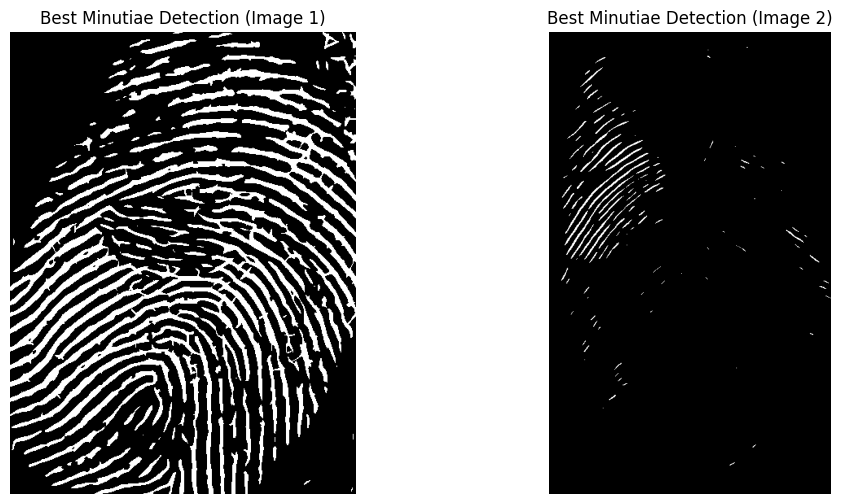

In [ ]:
# Save the two best quality minutiae images
cv2.imwrite("best_minutiae1.png", corners_enhanced1_harris)
cv2.imwrite("best_minutiae2.png", corners_enhanced2_harris)

# Load the saved images
best_min1 = cv2.imread("best_minutiae1.png", cv2.IMREAD_GRAYSCALE)
best_min2 = cv2.imread("best_minutiae2.png", cv2.IMREAD_GRAYSCALE)

# Display the best minutiae images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(best_min1, cmap="gray")
axes[0].set_title("Best Minutiae Detection (Image 1)")
axes[0].axis("off")

axes[1].imshow(best_min2, cmap="gray")
axes[1].set_title("Best Minutiae Detection (Image 2)")
axes[1].axis("off")

plt.show()

<!-- #### Step 10: Discussion -->

Add a disussion here.
Write a brief report (max 600 words) discussing which parameters affect the fingerprint quality the most, and explaining the contribution of each step above. Explain your resoning by referencing the intermediate result figures you generated. Think about the image content and justify your choices of kernel sizes, standard deviations, frequencies, bin counts etc. Did the same parameters work for both images, explain why/ why not? What are some of the limitations of the approach above?

Each step in this lab contributed to making a more enhanced fingerprint image. The Sobel filter was used in the first step to calculate the gradient. Sobel was critical for edge detection and was used in the later functions as well. The kernel size (ksize) in the Sobel filter significantly influences the level of detail captured, with a larger kernel capturing more prominent edges but potentially missing finer details. 18 was the best value I found for balancing detail and noise.

The Gabor filter was the next stage in enhancing the image, this function focused on capturing the orientations of the fingerprint texture. Changing the parameters here, sigma, frequency, and theta, had the largest effect on the outcome of the edge detection. As a result, both images used different values to try and get the clearest image. I found a larger sigma helped smooth the response, while the frequency parameter controlled the wavelength of the Gabor filters, enhancing ridge structures while mitigating noise. I found that dynamic thresholding to enhance the image had a minimal effect, as the regions with significant responses were already well-defined. However, by using dynamic thresholding I could change the parameters above and it would adjust. Additionally adjusting the bin count allowed for more orientations to be found, too many orientations resulted in noise, while too few missed important edge details. 

The corner detection step further refined the enhancement process. I applied both the Harris and Shi-Tomasi corner detection methods. The Harris method produced better results, showing clearer and more connected corners, while Shi-Tomasi highlighted the corners more distinctly but with less continuity. 
Harris method was better suited for the prominent ridge structures in the fingerprint images. This was shown in the first image while the second image was harder to enhance. The image quality and detail in the fingerprint made it hard for edge detection resulting in only the most defined areas getting detected. 

Using multiple stages of filtering and detection can make this process computationally expensive and sensitive to misconfiguration, which may affect the results. Small changes in parameters like kernel size or frequency resulted in drastically different results. For instance, the parameters that worked for the first image did not always work for the second, this highlighted a need for dynamic tuning of parameters. I found the second image was harder to enhance due to less contrast and more noise, making edge detection difficult. 

Despite the challenges, the process has highlighted the crucial role of kernel size, sigma, frequency, and other parameters in fingerprint enhancement and corner detection. By tuning these values, it's possible to improve the image quality significantly. Balancing detail and noise reduction is key, but comes with higher computation costs due to multiple stages or processing. 
The choice of parameter must be tailored to each specific image and misconfiguration can result in working with lower-quality images.